In [2]:
import json
import os
import argparse
import sys

import torch
from torch import nn, optim
from torch.nn import functional as F
from speaker_encoder import LSTM as model

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(""))))
import commons
import utils
from utils import load_filepaths_and_text, load_wav_to_torch

In [3]:
def audio_processing(audio_path, hps):
    audio, sr = load_wav_to_torch(audio_path)
    audio_norm = audio/ hps.data.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    stft = commons.TacotronSTFT(hps.data.filter_length, hps.data.hop_length, 
                               hps.data.win_length, hps.data.n_mel_channels, 
                               hps.data.sampling_rate, hps.data.mel_fmin,
                               hps.data.mel_fmax)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(torch.tensor(melspec),0)
    melspec = torch.abs(melspec)
    
    frames = hps.data.slice_length
    mel_padded = torch.FloatTensor(1, hps.data.n_mel_channels, frames)
    mel_padded.zero_()
    if melspec.size(1) < frames:
        mel_padded[:, :, :melspec.size(1)] = melspec
    else : 
        mel_padded[:, :, :frames] = melspec[:, :frames]
    return mel_padded/torch.max(mel_padded)

In [6]:
saved_model_path = "/media/caijb/data_drive/GE2E/log/LSTM"
config_path = os.path.join(saved_model_path, "config.json")
with open(config_path,"r") as f:
        data = f.read()
config = json.loads(data)
hps = utils.HParams(**config)


#checkpoint_path = utils.latest_checkpoint_path(saved_model_path)
checkpoint_path = os.path.join(saved_model_path, 'EMB_120.pth')
CAC = model(input_size=hps.data.n_mel_channels, hidden_size=hps.model.l_hidden,embedding_size= hps.model.embedding_size
            , num_layers=hps.model.num_layers)

CAC, _, _, _ = utils.load_checkpoint(checkpoint_path, CAC)

INFO:root:Loaded checkpoint '/media/caijb/data_drive/GE2E/log/LSTM/EMB_120.pth' (iteration 120)


In [8]:
text_path = "/media/caijb/data_drive/data/Zeroshot/vctk_tester.txt"
with open(text_path, "r") as f:
    data = f.read()
    data = data.split("\n")

    
result = []
for i in data:
    i = i.split("|")
    audio_path, sid = i[0], i[1]
    print(audio_path)
    mel = audio_processing(audio_path, hps)
    vector = CAC(mel)
    #vector = vector.squeeze()
    temp_vector = vector.tolist()
    temp_vector.append(int(sid))
    result.append(temp_vector)


/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_009.wav


/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


RuntimeError: input.size(-1) must be equal to input_size. Expected 80, got 430

In [5]:
import pandas as pd

df = pd.DataFrame(result)
#df.to_csv("./result_seen.csv")

In [6]:
import matplotlib.pyplot as plt
df.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.090479,0.027249,0.068876,0.046514,0.043302,0.040566,-0.004987,-0.029238,-0.013886,-0.014279,...,-0.064948,0.032851,0.024236,-0.037492,0.010109,-0.014445,0.059455,-0.037614,0.013767,2
1,-0.013680,-0.010990,-0.029377,-0.032276,0.012549,-0.014356,0.053102,-0.021164,0.039867,0.012338,...,-0.019115,-0.036301,0.021456,0.000858,-0.016963,-0.014746,0.000314,-0.034903,0.010951,2
2,0.002728,-0.022807,-0.061000,-0.045168,0.021274,-0.033501,0.132868,-0.001276,-0.035671,-0.026024,...,-0.028799,-0.023705,0.013337,0.014546,-0.004546,0.049708,0.054642,0.025113,0.016720,2
3,0.121962,-0.094429,0.016251,-0.066567,0.043523,-0.239597,-0.099682,0.057693,0.067126,0.001666,...,-0.002651,0.042361,-0.013857,0.064948,-0.176408,0.055768,0.119238,0.084479,-0.025071,2
4,-0.009419,0.031573,0.007807,0.029015,-0.033695,0.037514,0.008581,0.023114,-0.012721,-0.025765,...,-0.027814,0.026492,0.002588,-0.015395,-0.036455,-0.050219,0.023138,-0.042009,0.003866,2


In [7]:
y = df[[256]]
"""
y =y.replace(125,0)
y =y.replace(124,1)
y =y.replace(113,2)
y =y.replace(115,3)
y =y.replace(114,4)

"""
y =y.replace(2,0)
y =y.replace(3,1)
y =y.replace(4,2)
y =y.replace(5,3)
y =y.replace(6,4)

x = df.drop([256],axis =1)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [9]:
from sklearn.decomposition import PCA
pca =PCA(n_components = 2)
pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
x_pca= pd.DataFrame(x_pca)
x_pca['target']=y

In [10]:
markers = ['o', '^', 's', 'x','p']
name = ['125', '124','113', '115', '114']
sid_list = [125, 124, 113, 115, 114]

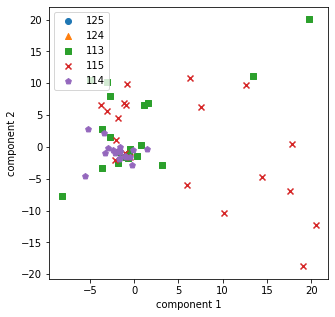

In [11]:
fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_pca[x_pca['target']==i][0]
    y_axis = x_pca[x_pca['target']==i][1]
    
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='upper left')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda= LinearDiscriminantAnalysis(n_components =2)
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x)
lda.fit(x_scaled,y)
x_lda = lda.transform(x_scaled)
x_lda = pd.DataFrame(x_lda)
x_lda['target'] = y

/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
import sklearn.externals import joblib
save_model = joblib.dump(lda,'lda.pkl')

SyntaxError: invalid syntax (3717891824.py, line 1)

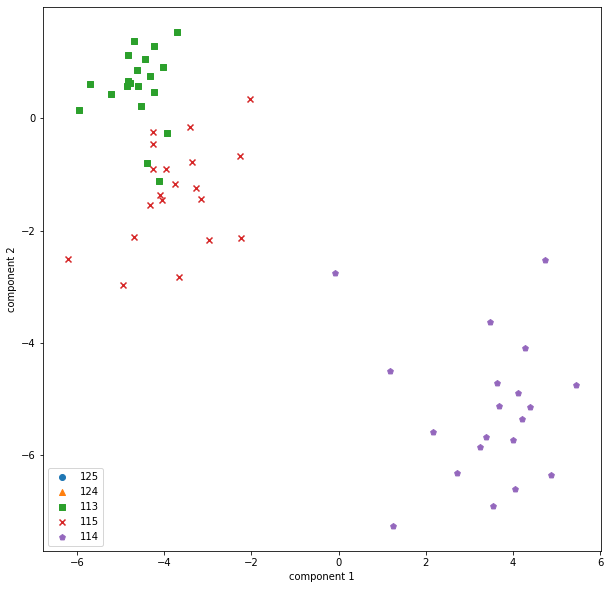

In [14]:
fig = plt.figure(figsize=(10,10))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_lda[x_lda['target']==i][0]
    y_axis = x_lda[x_lda['target']==i][1]
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='lower left')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()